In [2]:
# Imports
from bs4 import BeautifulSoup
from pathlib import Path
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Extract data from the Excel file

In [40]:
def read_xlsx_desc(xlsx_file="", output_folder_dest="", multiple_file=False):
    """
        Read and extract all desc and save them into file(s)

        Parameters:
            xlsx_file (str): 

            output_folder_dest (str):

            multiple_file (boolean):

    """
    df = pd.read_excel(xlsx_file, engine='openpyxl')

    if multiple_file is False:
        file = str(output_folder_dest + "desc_extracted.txt")
        with open(file, 'w', encoding="utf-8") as f:
            for index, row in df.iterrows():
                description = str(row["desc"])
                if len(description) != 0 and description != "nan":
                    f.write(description + "\n")

    else:
        for index, row in df.iterrows():
            desc = str(row["desc"])
            if len(desc) != 0:
                file_name = output_folder_dest + f"row_{index}_corpus.txt"
                with open(file_name, 'w', encoding="utf-8") as f:
                    f.write(desc)

read_xlsx_desc("ressources/NER_weekday_raw.xlsx", "Result/Corpus/", multiple_file=False)

## Run CasEn on text file(s)

In [3]:
# Run CasEN

## Extract the data

In [ ]:
def extract_entities_from_element(element):
    """
        Extract each entities from a beautiful soup element

        Parameters:
            element (BeautifulSoup element): BeautifulSoup element

        Returns:
            dict
    
    """
    # with open("CasEn_Result.txt", 'a', encoding="utf-8") as f:
    #     f.write(str(element) + "\n")

    tag = element.name
    text = element.get_text()
    grf = element.attrs.get("grf")
    
    data = {
        "tag": tag,
        "grf": grf,
        "text": text,
    }
    
    # Check if there is child
    children = element.find_all(recursive=False)

    if children:
        children_data = {}
        for child in children:
            child_data = extract_entities_from_element(child)
            # Si plusieurs enfants ont le même tag, on les met dans une liste.
            child_tag = child_data["tag"]
            if child_tag in children_data:
                # Si ce n'est pas déjà une liste, on transforme la valeur existante en liste.
                if not isinstance(children_data[child_tag], list):
                    children_data[child_tag] = [children_data[child_tag]]
                children_data[child_tag].append(child_data)
            else:
                children_data[child_tag] = child_data
        data.update(children_data)
    
    return data

def extract_entities_from_file(file_path=""):
    """
        Read and extract entities from one file
    """
    entities_from_this_file = []

    with open(file_path, 'r', encoding="utf-8") as f:
        file_content = f.read()
        soup = BeautifulSoup(file_content, "html.parser")

        # ------------------list of tag that we don't care --------------------
        excluded_tags = ["s", "p"]

        for element in soup.find_all(lambda tag: tag.name not in excluded_tags):
            entities_from_this_file.append(extract_entities_from_element(element))

    return entities_from_this_file

def extract_entities(folder_path=""):
    """
        Extract entities from CasEN result in all txt file in the folder

        Parameters:
            folder_path (str): The path for the folder
    """

    extracted_entities = []

    path = Path(folder_path)
    if path.is_dir():
        txt_files = list(path.glob("*.txt"))
        if len(txt_files) != 0:
            for file in txt_files:
                extracted_entities.append(
                    {
                        "filename" : file.name,
                        "entities" : extract_entities_from_file(file)
                    }
                )
        else:
            print(f"No .txt file were found in {folder_path}")
    else:
        print(f"{folder_path} is not a folder")

    return extracted_entities

def save_extracted_informations(output_file="", extract={}):
    """
        Save informations in a json file

        Parameters:
            output_files (str): the destination file for save

            extract (dict): Dictionnary to save in json format
    """
    # Save result in a readable JSON file
    with open(output_file, "w", encoding="utf-8") as f:
        json.dump(extract, f, indent=2, ensure_ascii=False)


In [44]:
extract = extract_entities("Result/CasEN_Result/Res_CasEN_Analyse_synthese_grf")
save_extracted_informations("Result/json/saved.json", extract)

### Analyse

In [45]:
def analyse_entity(entity):

    entity_info = {
         "tag": entity.get("tag", ""),
        "grf": entity.get("grf", ""),
    }
    return entity_info 

def analyse_file(json_result={}, file_path=""):

    list_entities_analyse = []
    
    # Compter le nombre de mot dans le text original
    with open(file_path, 'r', encoding="utf-8") as f:
        original_text = f.read()

    nb_words = len(original_text)

    # Pour chaque entitées dans le fichier faire un dictionnaire 
    list_entities = json_result.get("entities", [])

    file_infos = {
        "filename" : json_result.get("filename"),
        "nb_words" : nb_words
    }

    for entity in list_entities:
        entity_analyse = analyse_entity(entity)
        list_entities_analyse.append(file_infos | entity_analyse)

    return list_entities_analyse

def analyse_all_files(json_file_path="", original_text_folder_path=""):
    """
        Analyzes the extracted named entities in comparison with the original text files

        Parameters:
            json_file_path (str): Path to the JSON file containing extracted entities

            original_text_folder_path (str): Path to the folder containing the original text files (corpus)
    """

    # Read the JSON data
    with open(json_file_path, 'r', encoding="utf-8") as f:
        json_data = json.load(f)

    original_folder = Path(original_text_folder_path)
    # list containing tuple for every text with the original text and the JSON result
    origin_json = []

    for result in json_data:
        result_name = result["filename"]
        original_name = result_name.replace(".result", "")
        original_path = Path(original_folder/original_name)

        if original_path.exists():
            origin_json.append((result, str(original_path)))
        else:
            print(f"Original file not foun  d for the result file : {result_name}")

    # For every files_pair run analyse 
    analyses = []

    for json_result, path in origin_json:
        analyse = analyse_file(json_result, path)
        analyses.extend(analyse)

    return analyses

In [46]:
analyse = analyse_all_files("Result/json/saved.json", "Result/Corpus")
df = pd.DataFrame(analyse)

In [12]:
# df.to_csv("Result/csv/analyse.csv")
# df.head()

#  Analyse of the result

In [29]:
def show_grf_for_tag(df, tag, X_size=8, Y_size=6):
    """
    Display a bar chart showing which 'grf' values are associated with a given tag.

    Parameters:
        df (pandas.DataFrame): The input DataFrame containing at least 'tag' and 'grf' columns.
        tag (str): The specific tag to filter the DataFrame on.

    Returns:
        None. Displays a matplotlib bar chart.
    """
    
    # Filter the DataFrame to only include rows with the specified tag
    df_filtered = df[df["tag"] == str(tag)]

    # Count the occurrences of each 'grf' value
    grf_counts = df_filtered['grf'].value_counts()

    # Create the bar chart
    plt.figure(figsize=(X_size, Y_size))
    bars = plt.bar(grf_counts.index, grf_counts.values, color='skyblue')
    plt.xlabel("GRF", fontsize=12)
    plt.ylabel("Number of Occurrences", fontsize=12)
    plt.title(f"GRF Occurrences for the tag : '{tag}'", fontsize=14)

    # Annotate each bar with its count
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height,
                 f'{int(height)}', ha='center', va='bottom', fontsize=12)

    # Improve readability of x-axis labels
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

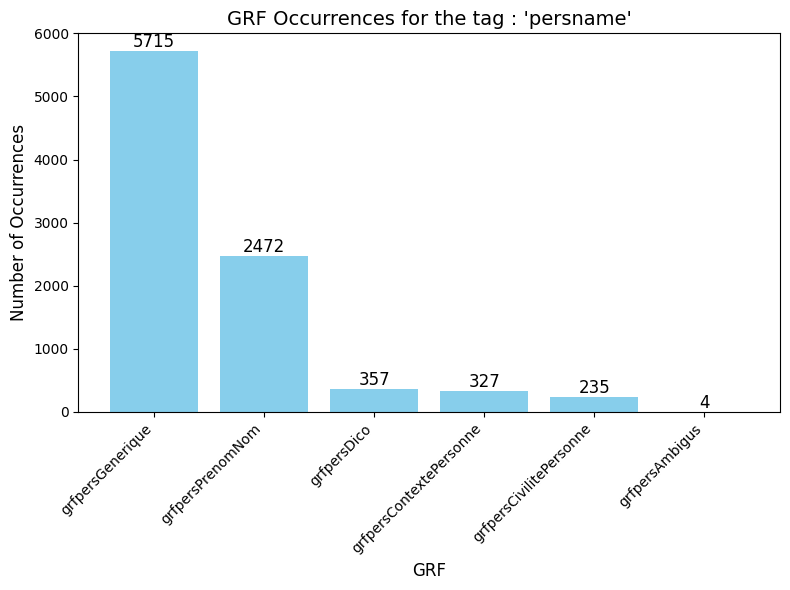

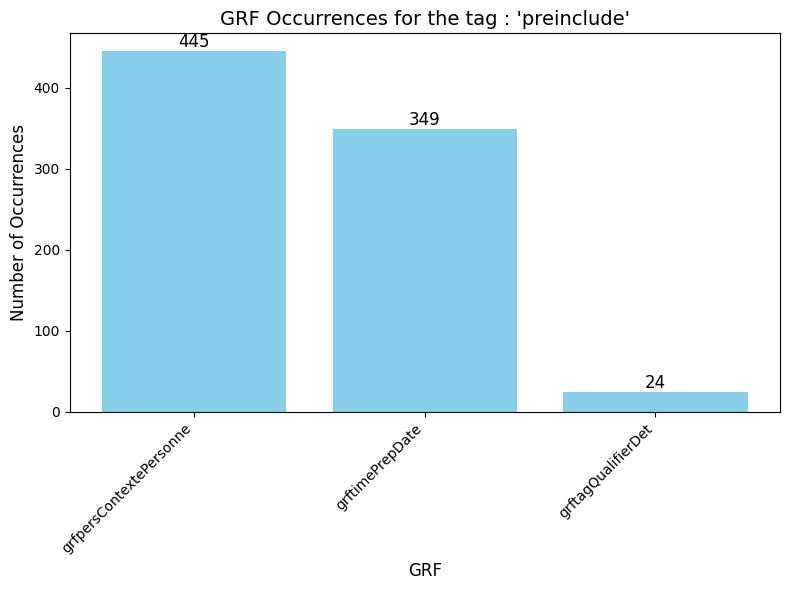

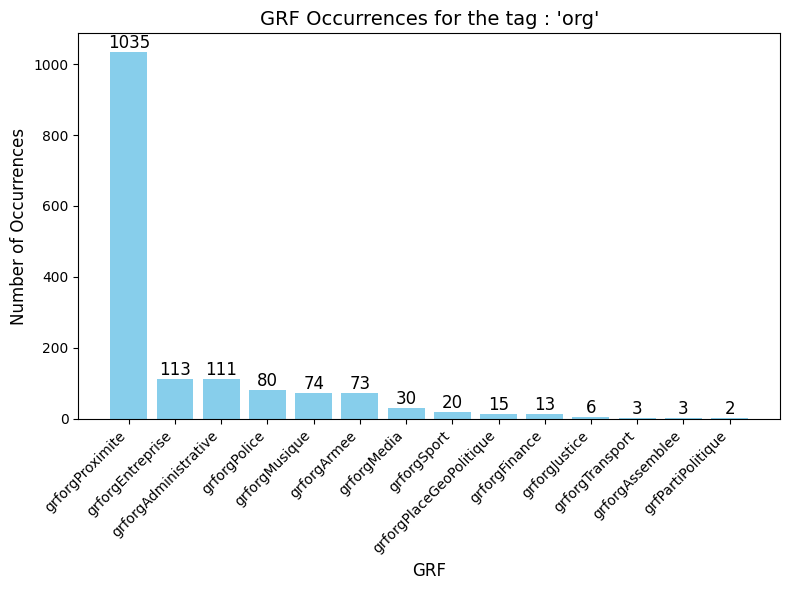

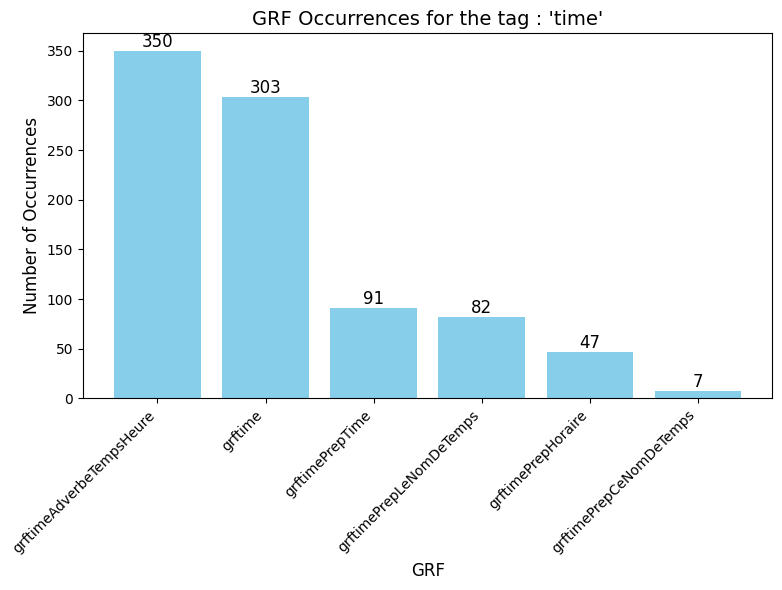

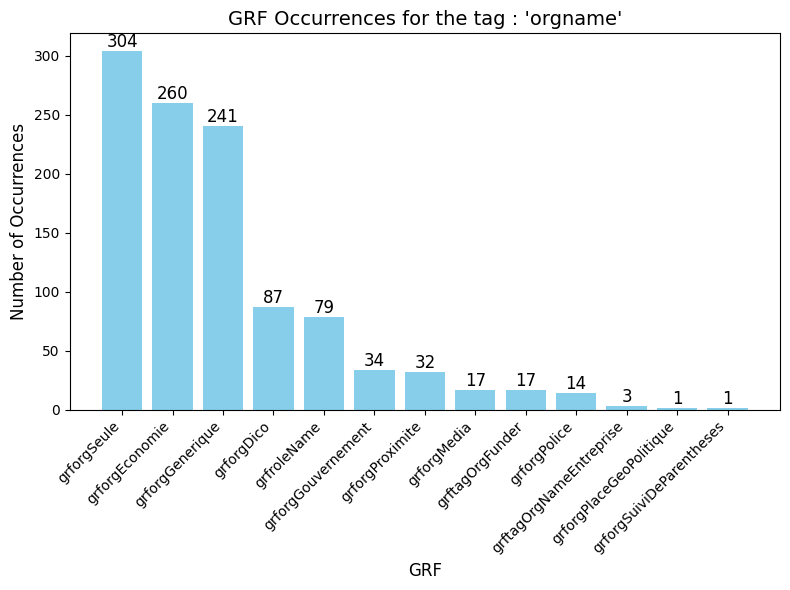

In [53]:
entity_name = ["persname","preinclude", "org", "time", "orgname"]
for name in entity_name:
    show_grf_for_tag(df, name)